# 🎓 Tamil Nadu Teacher Shortages & Learning Outcomes Dashboard

**A Data-Driven Approach to Equitable Education Planning (2025)**

This notebook consolidates the entire Tamil Nadu Education Dashboard project into a single executable workflow.

### 📊 Project Overview
- **Identify disparities** in teacher deployment across Tamil Nadu districts
- **Correlate** teacher-student ratios with learning outcomes (SLAS 2025)
- **Forecast** future teacher requirements using demographic trends
- **Recommend** targeted policy interventions for underserved regions

### 🔧 Python Version
- Tested on Python 3.11.0
- Compatible with Python 3.9+

---

## 1️⃣ Setup & Installation

Install required packages (run once)

In [2]:
# Install required packages
# Uncomment and run the following line if packages are not installed:
!pip install pandas numpy matplotlib seaborn plotly scikit-learn scipy statsmodels requests openpyxl -q

## 2️⃣ Import Libraries & Setup

In [3]:
# Import all required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from pathlib import Path
import logging
import warnings
from typing import Dict, List, Tuple, Optional
from datetime import datetime

# Scientific computing
from scipy import stats
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Suppress warnings
warnings.filterwarnings('ignore')

# Setup logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

# Configure pandas display
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.2f}'.format)

print("✅ All libraries imported successfully!")
print(f"📦 Pandas version: {pd.__version__}")
print(f"📦 NumPy version: {np.__version__}")

✅ All libraries imported successfully!
📦 Pandas version: 2.2.2
📦 NumPy version: 1.26.4


## 3️⃣ Project Configuration & Utilities

In [4]:
# Project paths - Fixed for Jupyter notebook
BASE_DIR = Path.cwd()  # Current working directory
DATA_DIR = BASE_DIR / 'data'
RAW_DATA_DIR = DATA_DIR / 'raw'
PROCESSED_DATA_DIR = DATA_DIR / 'processed'
GEO_DATA_DIR = DATA_DIR / 'geospatial'
OUTPUT_DIR = BASE_DIR / 'outputs'

# Create directories if they don't exist
for directory in [RAW_DATA_DIR, PROCESSED_DATA_DIR, GEO_DATA_DIR, OUTPUT_DIR]:
    directory.mkdir(parents=True, exist_ok=True)

print(f"📁 Base Directory: {BASE_DIR}")
print(f"📁 Data Directory: {DATA_DIR}")
print("✅ All directories created successfully!")

📁 Base Directory: d:\project\Tamil_Nadu_Teacher_Shortage_& _Learning_Outcomes_Dashboard
📁 Data Directory: d:\project\Tamil_Nadu_Teacher_Shortage_& _Learning_Outcomes_Dashboard\data
✅ All directories created successfully!


In [5]:
# Tamil Nadu District Name Standardization
DISTRICT_NAME_MAPPING = {
    'Chennai': 'Chennai',
    'Kanchipuram': 'Kancheepuram',
    'Kancheepuram': 'Kancheepuram',
    'Thiruvallur': 'Tiruvallur',
    'Tiruvallur': 'Tiruvallur',
    'Villupuram': 'Viluppuram',
    'Viluppuram': 'Viluppuram',
    'Cuddalore': 'Cuddalore',
    'Vellore': 'Vellore',
    'Tiruvannamalai': 'Tiruvannamalai',
    'Salem': 'Salem',
    'Namakkal': 'Namakkal',
    'Erode': 'Erode',
    'The Nilgiris': 'Nilgiris',
    'Nilgiris': 'Nilgiris',
    'Coimbatore': 'Coimbatore',
    'Tiruppur': 'Tiruppur',
    'Karur': 'Karur',
    'Tiruchirappalli': 'Tiruchirappalli',
    'Trichy': 'Tiruchirappalli',
    'Perambalur': 'Perambalur',
    'Ariyalur': 'Ariyalur',
    'Thanjavur': 'Thanjavur',
    'Tiruvarur': 'Tiruvarur',
    'Nagapattinam': 'Nagapattinam',
    'Pudukkottai': 'Pudukkottai',
    'Dindigul': 'Dindigul',
    'Madurai': 'Madurai',
    'Theni': 'Theni',
    'Virudhunagar': 'Virudhunagar',
    'Ramanathapuram': 'Ramanathapuram',
    'Sivaganga': 'Sivagangai',
    'Sivagangai': 'Sivagangai',
    'Thoothukudi': 'Thoothukudi',
    'Tuticorin': 'Thoothukudi',
    'Tirunelveli': 'Tirunelveli',
    'Kanniyakumari': 'Kanniyakumari',
    'Kanyakumari': 'Kanniyakumari',
    'Dharmapuri': 'Dharmapuri',
    'Krishnagiri': 'Krishnagiri',
    'Ranipet': 'Ranipet',
    'Tirupattur': 'Tirupattur',
    'Chengalpattu': 'Chengalpattu',
    'Kallakurichi': 'Kallakurichi',
    'Tenkasi': 'Tenkasi',
    'Mayiladuthurai': 'Mayiladuthurai',
}

# Tamil Nadu Districts (38 districts as of 2025)
TN_DISTRICTS = [
    'Ariyalur', 'Chengalpattu', 'Chennai', 'Coimbatore', 'Cuddalore',
    'Dharmapuri', 'Dindigul', 'Erode', 'Kallakurichi', 'Kancheepuram',
    'Kanniyakumari', 'Karur', 'Krishnagiri', 'Madurai', 'Mayiladuthurai',
    'Nagapattinam', 'Namakkal', 'Nilgiris', 'Perambalur', 'Pudukkottai',
    'Ramanathapuram', 'Ranipet', 'Salem', 'Sivagangai', 'Tenkasi',
    'Thanjavur', 'Theni', 'Thoothukudi', 'Tiruchirappalli', 'Tirunelveli',
    'Tirupattur', 'Tiruppur', 'Tiruvallur', 'Tiruvannamalai', 'Tiruvarur',
    'Vellore', 'Viluppuram', 'Virudhunagar'
]

print(f"📍 Total Districts: {len(TN_DISTRICTS)}")

📍 Total Districts: 38


In [6]:
# Utility Functions

def standardize_district_names(df: pd.DataFrame, column: str = 'District') -> pd.DataFrame:
    """Standardize district names across datasets"""
    df = df.copy()
    
    if column in df.columns:
        df[column] = df[column].str.strip().str.title()
        df[column] = df[column].map(DISTRICT_NAME_MAPPING).fillna(df[column])
        
        unmapped = set(df[column].unique()) - set(TN_DISTRICTS)
        if unmapped:
            logger.warning(f"Unmapped districts found: {unmapped}")
    
    return df


def calculate_ptr(df: pd.DataFrame, 
                  enrollment_col: str = 'Total_Enrollment',
                  teachers_col: str = 'Total_Teachers') -> pd.Series:
    """Calculate Pupil-Teacher Ratio (PTR)"""
    ptr = df[enrollment_col] / df[teachers_col].replace(0, np.nan)
    return ptr.round(2)


def categorize_ptr(ptr: float) -> str:
    """Categorize PTR into performance bands"""
    if pd.isna(ptr):
        return 'Unknown'
    elif ptr <= 20:
        return 'Excellent (≤20)'
    elif ptr <= 30:
        return 'Good (21-30)'
    elif ptr <= 35:
        return 'Adequate (31-35)'
    elif ptr <= 40:
        return 'Needs Improvement (36-40)'
    else:
        return 'Critical (>40)'


def categorize_learning_outcome(score: float) -> str:
    """Categorize learning outcome scores"""
    if pd.isna(score):
        return 'Unknown'
    elif score >= 80:
        return 'Excellent (≥80%)'
    elif score >= 60:
        return 'Good (60-79%)'
    elif score >= 40:
        return 'Satisfactory (40-59%)'
    elif score >= 20:
        return 'Needs Improvement (20-39%)'
    else:
        return 'Critical (<20%)'


def calculate_teacher_deficit(df: pd.DataFrame,
                              ideal_ptr: float = 30,
                              enrollment_col: str = 'Total_Enrollment',
                              teachers_col: str = 'Total_Teachers') -> pd.Series:
    """Calculate teacher deficit/surplus based on ideal PTR"""
    required_teachers = (df[enrollment_col] / ideal_ptr).round()
    deficit = required_teachers - df[teachers_col]
    return deficit.astype(int)


def detect_outliers_iqr(series: pd.Series, 
                        multiplier: float = 1.5) -> Tuple[pd.Series, float, float]:
    """Detect outliers using IQR method"""
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - multiplier * IQR
    upper_bound = Q3 + multiplier * IQR
    
    outliers = (series < lower_bound) | (series > upper_bound)
    
    return outliers, lower_bound, upper_bound


def save_processed_data(df: pd.DataFrame, filename: str) -> None:
    """Save processed data in CSV format"""
    filepath = PROCESSED_DATA_DIR / f"{filename}.csv"
    df.to_csv(filepath, index=False)
    logger.info(f"Saved {filepath}")


def load_processed_data(filename: str) -> pd.DataFrame:
    """Load processed data"""
    filepath = PROCESSED_DATA_DIR / f"{filename}.csv"
    
    if not filepath.exists():
        raise FileNotFoundError(f"File not found: {filepath}")
    
    return pd.read_csv(filepath)


print("✅ Utility functions defined successfully!")

✅ Utility functions defined successfully!


## 4️⃣ Data Collection & Generation

Generate synthetic data based on publicly available information from SLAS 2025 and UDISEPlus.

**Note:** In production, replace with actual data downloads from official sources.

In [7]:
def create_sample_slas_data():
    """Create sample SLAS 2025 learning outcomes data"""
    logger.info("Creating sample SLAS 2025 learning outcomes data...")
    
    # Set seed for reproducibility
    np.random.seed(42)
    
    # Top performing districts (reported in news)
    top_performers = ['Kanniyakumari', 'Cuddalore', 'Madurai', 'Tenkasi', 'Sivagangai']
    
    data = []
    
    for district in TN_DISTRICTS:
        if district in top_performers:
            base_score = np.random.uniform(70, 85)
        elif district in ['Chennai', 'Coimbatore', 'Tiruchirappalli']:
            base_score = np.random.uniform(60, 75)
        else:
            base_score = np.random.uniform(45, 70)
        
        data.append({
            'District': district,
            'Class_3_Tamil': base_score + np.random.uniform(-5, 5),
            'Class_3_English': base_score + np.random.uniform(-8, 3),
            'Class_3_Mathematics': base_score + np.random.uniform(-6, 4),
            'Class_5_Tamil': base_score + np.random.uniform(-3, 5),
            'Class_5_English': base_score + np.random.uniform(-10, 2),
            'Class_5_Mathematics': base_score + np.random.uniform(-7, 3),
            'Class_5_Science': base_score + np.random.uniform(-5, 5),
            'Class_5_Social': base_score + np.random.uniform(-4, 6),
            'Class_8_Tamil': base_score + np.random.uniform(-2, 4),
            'Class_8_English': base_score + np.random.uniform(-12, 0),
            'Class_8_Mathematics': base_score + np.random.uniform(-10, 2),
            'Class_8_Science': base_score + np.random.uniform(-8, 3),
            'Class_8_Social': base_score + np.random.uniform(-5, 5),
            'Students_Assessed': np.random.randint(15000, 40000),
            'Schools_Covered': np.random.randint(800, 1500),
        })
    
    df = pd.DataFrame(data)
    
    # Round scores and ensure they're within 0-100
    score_columns = [col for col in df.columns if 'Class' in col]
    df[score_columns] = df[score_columns].clip(0, 100).round(2)
    
    # Calculate overall averages
    df['Class_3_Average'] = df[['Class_3_Tamil', 'Class_3_English', 'Class_3_Mathematics']].mean(axis=1).round(2)
    df['Class_5_Average'] = df[['Class_5_Tamil', 'Class_5_English', 'Class_5_Mathematics', 
                                  'Class_5_Science', 'Class_5_Social']].mean(axis=1).round(2)
    df['Class_8_Average'] = df[['Class_8_Tamil', 'Class_8_English', 'Class_8_Mathematics',
                                  'Class_8_Science', 'Class_8_Social']].mean(axis=1).round(2)
    df['Overall_Average'] = df[['Class_3_Average', 'Class_5_Average', 'Class_8_Average']].mean(axis=1).round(2)
    
    # Save
    filepath = RAW_DATA_DIR / 'slas_2025_learning_outcomes.csv'
    df.to_csv(filepath, index=False)
    logger.info(f"Saved SLAS data: {filepath}")
    
    return df


# Generate SLAS data
slas_df = create_sample_slas_data()
print(f"\n📊 SLAS 2025 Data Shape: {slas_df.shape}")
print(f"📊 State Average Learning Outcome: {slas_df['Overall_Average'].mean():.2f}%")
slas_df.head()

2025-10-30 23:03:38,184 - INFO - Creating sample SLAS 2025 learning outcomes data...
2025-10-30 23:03:38,300 - INFO - Saved SLAS data: d:\project\Tamil_Nadu_Teacher_Shortage_& _Learning_Outcomes_Dashboard\data\raw\slas_2025_learning_outcomes.csv



📊 SLAS 2025 Data Shape: (38, 20)
📊 State Average Learning Outcome: 58.67%


,District,Class_3_Tamil,Class_3_English,Class_3_Mathematics,Class_5_Tamil,Class_5_English,Class_5_Mathematics,Class_5_Science,Class_5_Social,Class_8_Tamil,Class_8_English,Class_8_Mathematics,Class_8_Science,Class_8_Social,Students_Assessed,Schools_Covered,Class_3_Average,Class_5_Average,Class_8_Average,Overall_Average
0,Ariyalur,58.87,54.42,54.35,52.61,46.24,47.94,58.03,56.37,56.61,42.61,56.00,55.52,51.49,20311,1076,55.88,52.24,52.45,53.52
1,Chengalpattu,61.55,52.51,54.67,61.64,55.24,53.90,65.17,58.76,58.98,55.86,55.03,63.25,60.10,18556,1446,56.24,58.94,58.64,57.94
2,Chennai,58.21,65.00,66.21,66.03,56.21,56.53,64.40,62.96,61.29,56.50,52.97,64.56,60.15,18943,1187,63.14,61.23,59.09,61.15
3,Coimbatore,64.88,62.69,60.52,69.43,63.98,67.07,68.62,66.65,68.21,53.74,57.03,57.17,62.93,38247,1137,62.70,67.15,59.82,63.22
4,Cuddalore,78.96,80.71,78.17,77.30,71.65,72.75,73.25,78.33,78.46,69.62,68.26,72.28,80.21,27666,1289,79.28,74.66,73.77,75.90


In [8]:
def create_sample_udise_data():
    """Create sample UDISEPlus 2024-25 data"""
    logger.info("Creating sample UDISEPlus 2024-25 data...")
    
    np.random.seed(42)
    
    data = []
    
    for district in TN_DISTRICTS:
        # Determine district type
        urban_districts = ['Chennai', 'Coimbatore', 'Madurai', 'Tiruchirappalli', 'Salem']
        tribal_districts = ['Nilgiris', 'Dharmapuri', 'Krishnagiri']
        
        if district in urban_districts:
            schools = np.random.randint(800, 1500)
            avg_enrollment = np.random.randint(350, 600)
            single_teacher_pct = np.random.uniform(1, 3)
        elif district in tribal_districts:
            schools = np.random.randint(600, 1000)
            avg_enrollment = np.random.randint(180, 300)
            single_teacher_pct = np.random.uniform(5, 10)
        else:
            schools = np.random.randint(700, 1200)
            avg_enrollment = np.random.randint(250, 400)
            single_teacher_pct = np.random.uniform(2, 6)
        
        total_enrollment = schools * avg_enrollment
        
        # Teacher calculations
        avg_ptr = np.random.uniform(25, 38)
        total_teachers = int(total_enrollment / avg_ptr)
        single_teacher_schools = int(schools * single_teacher_pct / 100)
        
        data.append({
            'District': district,
            'Total_Schools': schools,
            'Government_Schools': int(schools * np.random.uniform(0.75, 0.85)),
            'Aided_Schools': int(schools * np.random.uniform(0.10, 0.15)),
            'Total_Enrollment': total_enrollment,
            'Boys_Enrollment': int(total_enrollment * 0.5),
            'Girls_Enrollment': int(total_enrollment * 0.5),
            'SC_Enrollment': int(total_enrollment * np.random.uniform(0.15, 0.25)),
            'ST_Enrollment': int(total_enrollment * np.random.uniform(0.01, 0.05)),
            'Total_Teachers': total_teachers,
            'Male_Teachers': int(total_teachers * np.random.uniform(0.30, 0.45)),
            'Female_Teachers': int(total_teachers * np.random.uniform(0.55, 0.70)),
            'Single_Teacher_Schools': single_teacher_schools,
            'Schools_With_Electricity': int(schools * np.random.uniform(0.85, 0.98)),
            'Schools_With_Internet': int(schools * np.random.uniform(0.40, 0.75)),
            'Schools_With_Library': int(schools * np.random.uniform(0.60, 0.85)),
            'Schools_With_Computer_Lab': int(schools * np.random.uniform(0.45, 0.75)),
        })
    
    df = pd.DataFrame(data)
    
    # Calculate actual PTR
    df['PTR'] = (df['Total_Enrollment'] / df['Total_Teachers']).round(2)
    
    # Save
    filepath = RAW_DATA_DIR / 'udise_plus_2024_25.csv'
    df.to_csv(filepath, index=False)
    logger.info(f"Saved UDISEPlus data: {filepath}")
    
    return df


# Generate UDISEPlus data
udise_df = create_sample_udise_data()
print(f"\n📊 UDISEPlus Data Shape: {udise_df.shape}")
print(f"📊 State Average PTR: {udise_df['PTR'].mean():.2f}")
print(f"📊 Total Schools: {udise_df['Total_Schools'].sum():,}")
print(f"📊 Total Teachers: {udise_df['Total_Teachers'].sum():,}")
udise_df.head()

2025-10-30 23:03:38,350 - INFO - Creating sample UDISEPlus 2024-25 data...
2025-10-30 23:03:38,361 - INFO - Saved UDISEPlus data: d:\project\Tamil_Nadu_Teacher_Shortage_& _Learning_Outcomes_Dashboard\data\raw\udise_plus_2024_25.csv



📊 UDISEPlus Data Shape: (38, 18)
📊 State Average PTR: 31.93
📊 Total Schools: 36,503
📊 Total Teachers: 399,272


,District,Total_Schools,Government_Schools,Aided_Schools,Total_Enrollment,Boys_Enrollment,Girls_Enrollment,SC_Enrollment,ST_Enrollment,Total_Teachers,Male_Teachers,Female_Teachers,Single_Teacher_Schools,Schools_With_Electricity,Schools_With_Internet,Schools_With_Library,Schools_With_Computer_Lab,PTR
0,Ariyalur,802,649,98,274284,137142,137142,43884,7781,7806,2732,4460,21,749,336,625,586,35.14
1,Chengalpattu,1085,814,109,292950,146475,146475,59315,7615,8890,2729,6188,48,955,468,818,612,32.95
2,Chennai,1043,853,127,430759,215379,215379,65185,20542,11906,4577,7236,20,888,501,688,683,36.18
3,Coimbatore,1227,952,163,438039,219019,219019,79360,13492,11896,4544,6872,13,1197,823,1024,881,36.82
4,Cuddalore,969,745,99,333336,166668,166668,60844,8515,12746,4342,8594,55,868,482,712,477,26.15


In [9]:
def create_sample_demographic_data():
    """Create sample demographic data"""
    logger.info("Creating sample demographic data...")
    
    np.random.seed(42)
    
    data = []
    
    for district in TN_DISTRICTS:
        if district == 'Chennai':
            population = np.random.randint(5000000, 5500000)
        elif district in ['Coimbatore', 'Tiruchirappalli', 'Madurai']:
            population = np.random.randint(2500000, 3500000)
        else:
            population = np.random.randint(1000000, 2500000)
        
        school_age_pct = np.random.uniform(0.18, 0.25)
        
        data.append({
            'District': district,
            'Total_Population': population,
            'School_Age_Population': int(population * school_age_pct),
            'Literacy_Rate': np.random.uniform(65, 90),
            'Urban_Population_Pct': np.random.uniform(20, 80),
            'SC_Population_Pct': np.random.uniform(15, 30),
            'ST_Population_Pct': np.random.uniform(0.5, 8),
            'Population_Density': np.random.randint(200, 2000),
            'Birth_Rate': np.random.uniform(14, 20),
            'Child_Sex_Ratio': np.random.randint(940, 990),
        })
    
    df = pd.DataFrame(data)
    
    # Round numeric values
    df['Literacy_Rate'] = df['Literacy_Rate'].round(2)
    df['Urban_Population_Pct'] = df['Urban_Population_Pct'].round(2)
    
    # Save
    filepath = RAW_DATA_DIR / 'demographic_data_2025.csv'
    df.to_csv(filepath, index=False)
    logger.info(f"Saved demographic data: {filepath}")
    
    return df


# Generate demographic data
demo_df = create_sample_demographic_data()
print(f"\n📊 Demographic Data Shape: {demo_df.shape}")
print(f"📊 Total Population: {demo_df['Total_Population'].sum():,}")
print(f"📊 Average Literacy Rate: {demo_df['Literacy_Rate'].mean():.2f}%")
demo_df.head()

2025-10-30 23:03:38,405 - INFO - Creating sample demographic data...
2025-10-30 23:03:38,417 - INFO - Saved demographic data: d:\project\Tamil_Nadu_Teacher_Shortage_& _Learning_Outcomes_Dashboard\data\raw\demographic_data_2025.csv



📊 Demographic Data Shape: (38, 10)
📊 Total Population: 74,324,354
📊 Average Literacy Rate: 77.20%


,District,Total_Population,School_Age_Population,Literacy_Rate,Urban_Population_Pct,SC_Population_Pct,ST_Population_Pct,Population_Density,Birth_Rate,Child_Sex_Ratio
0,Ariyalur,1121958,264510,69.59,66.78,23.95,3.84,1438,14.35,963
1,Chengalpattu,1912756,424781,82.70,21.24,29.55,6.74,1005,14.00,960
2,Chennai,5214176,1049597,78.12,45.92,19.37,5.09,1905,14.28,955
3,Coimbatore,2952366,625679,84.63,31.98,22.71,4.94,1354,19.16,946
4,Cuddalore,1489492,315079,65.33,76.53,23.45,3.39,1569,14.59,959


## 5️⃣ Data Processing & Integration

In [10]:
def clean_slas_data(df):
    """Clean and enrich SLAS learning outcomes data"""
    logger.info("Cleaning SLAS data...")
    
    df = df.copy()
    df = standardize_district_names(df, 'District')
    
    # Add performance categories
    df['Class_3_Category'] = df['Class_3_Average'].apply(categorize_learning_outcome)
    df['Class_5_Category'] = df['Class_5_Average'].apply(categorize_learning_outcome)
    df['Class_8_Category'] = df['Class_8_Average'].apply(categorize_learning_outcome)
    df['Overall_Category'] = df['Overall_Average'].apply(categorize_learning_outcome)
    
    # Calculate state averages
    state_avg_3 = df['Class_3_Average'].mean()
    state_avg_5 = df['Class_5_Average'].mean()
    state_avg_8 = df['Class_8_Average'].mean()
    state_avg_overall = df['Overall_Average'].mean()
    
    # Deviation from state average
    df['Class_3_vs_State'] = df['Class_3_Average'] - state_avg_3
    df['Class_5_vs_State'] = df['Class_5_Average'] - state_avg_5
    df['Class_8_vs_State'] = df['Class_8_Average'] - state_avg_8
    df['Overall_vs_State'] = df['Overall_Average'] - state_avg_overall
    
    # Performance rank
    df['Overall_Rank'] = df['Overall_Average'].rank(ascending=False, method='min').astype(int)
    
    logger.info(f"State averages - Class 3: {state_avg_3:.2f}, Class 5: {state_avg_5:.2f}, "
                f"Class 8: {state_avg_8:.2f}, Overall: {state_avg_overall:.2f}")
    
    return df


# Clean SLAS data
slas_clean = clean_slas_data(slas_df)
print(f"✅ SLAS data cleaned. Shape: {slas_clean.shape}")
slas_clean[['District', 'Overall_Average', 'Overall_Rank', 'Overall_Category']].head(10)

2025-10-30 23:03:38,473 - INFO - Cleaning SLAS data...
2025-10-30 23:03:38,490 - INFO - State averages - Class 3: 58.92, Class 5: 59.05, Class 8: 58.02, Overall: 58.67


✅ SLAS data cleaned. Shape: (38, 29)


,District,Overall_Average,Overall_Rank,Overall_Category
0,Ariyalur,53.52,23,Satisfactory (40-59%)
1,Chengalpattu,57.94,18,Satisfactory (40-59%)
2,Chennai,61.15,16,Good (60-79%)
3,Coimbatore,63.22,14,Good (60-79%)
4,Cuddalore,75.90,5,Good (60-79%)
5,Dharmapuri,52.37,26,Satisfactory (40-59%)
6,Dindigul,57.04,19,Satisfactory (40-59%)
7,Erode,49.92,29,Satisfactory (40-59%)
8,Kallakurichi,45.81,33,Satisfactory (40-59%)
9,Kancheepuram,52.53,25,Satisfactory (40-59%)


In [11]:
def clean_udise_data(df):
    """Clean and enrich UDISEPlus data"""
    logger.info("Cleaning UDISEPlus data...")
    
    df = df.copy()
    df = standardize_district_names(df, 'District')
    
    # Recalculate PTR
    df['PTR_Calculated'] = calculate_ptr(df, 'Total_Enrollment', 'Total_Teachers')
    
    # Add PTR category
    df['PTR_Category'] = df['PTR_Calculated'].apply(categorize_ptr)
    
    # Calculate teacher deficit
    df['Teacher_Deficit_PTR30'] = calculate_teacher_deficit(df, ideal_ptr=30)
    df['Teacher_Deficit_PTR25'] = calculate_teacher_deficit(df, ideal_ptr=25)
    
    # Single teacher school percentage
    df['Single_Teacher_School_Pct'] = (df['Single_Teacher_Schools'] / df['Total_Schools'] * 100).round(2)
    
    # Infrastructure scores
    infra_cols = ['Schools_With_Electricity', 'Schools_With_Internet', 
                  'Schools_With_Library', 'Schools_With_Computer_Lab']
    
    for col in infra_cols:
        pct_col = f"{col}_Pct"
        df[pct_col] = (df[col] / df['Total_Schools'] * 100).round(2)
    
    df['Infrastructure_Score'] = df[[f"{col}_Pct" for col in infra_cols]].mean(axis=1).round(2)
    
    # Gender parity index (GPI)
    df['GPI_Enrollment'] = (df['Girls_Enrollment'] / df['Boys_Enrollment']).round(3)
    df['GPI_Teachers'] = (df['Female_Teachers'] / df['Male_Teachers']).round(3)
    
    return df


# Clean UDISE data
udise_clean = clean_udise_data(udise_df)
print(f"✅ UDISEPlus data cleaned. Shape: {udise_clean.shape}")
print(f"📊 Average PTR: {udise_clean['PTR_Calculated'].mean():.2f}")
print(f"📊 Total Teacher Deficit (PTR 30): {udise_clean['Teacher_Deficit_PTR30'].sum():,}")
udise_clean[['District', 'PTR_Calculated', 'PTR_Category', 'Teacher_Deficit_PTR30']].head(10)

2025-10-30 23:03:38,528 - INFO - Cleaning UDISEPlus data...


✅ UDISEPlus data cleaned. Shape: (38, 30)
📊 Average PTR: 31.93
📊 Total Teacher Deficit (PTR 30): 18,177


,District,PTR_Calculated,PTR_Category,Teacher_Deficit_PTR30
0,Ariyalur,35.14,Needs Improvement (36-40),1337
1,Chengalpattu,32.95,Adequate (31-35),875
2,Chennai,36.18,Needs Improvement (36-40),2453
3,Coimbatore,36.82,Needs Improvement (36-40),2705
4,Cuddalore,26.15,Good (21-30),-1635
5,Dharmapuri,37.84,Needs Improvement (36-40),950
6,Dindigul,26.24,Good (21-30),-1278
7,Erode,31.80,Adequate (31-35),703
8,Kallakurichi,26.00,Good (21-30),-1240
9,Kancheepuram,30.55,Adequate (31-35),239


In [12]:
def clean_demographic_data(df):
    """Clean demographic data"""
    logger.info("Cleaning demographic data...")
    
    df = df.copy()
    df = standardize_district_names(df, 'District')
    
    return df


# Clean demographic data
demo_clean = clean_demographic_data(demo_df)
print(f"✅ Demographic data cleaned. Shape: {demo_clean.shape}")
demo_clean.head()

2025-10-30 23:03:38,597 - INFO - Cleaning demographic data...


✅ Demographic data cleaned. Shape: (38, 10)


,District,Total_Population,School_Age_Population,Literacy_Rate,Urban_Population_Pct,SC_Population_Pct,ST_Population_Pct,Population_Density,Birth_Rate,Child_Sex_Ratio
0,Ariyalur,1121958,264510,69.59,66.78,23.95,3.84,1438,14.35,963
1,Chengalpattu,1912756,424781,82.70,21.24,29.55,6.74,1005,14.00,960
2,Chennai,5214176,1049597,78.12,45.92,19.37,5.09,1905,14.28,955
3,Coimbatore,2952366,625679,84.63,31.98,22.71,4.94,1354,19.16,946
4,Cuddalore,1489492,315079,65.33,76.53,23.45,3.39,1569,14.59,959


In [13]:
def merge_all_datasets(slas_df, udise_df, demo_df):
    """Merge all cleaned datasets"""
    logger.info("Merging all datasets...")
    
    # Start with UDISE as base
    merged = udise_df.copy()
    
    # Merge SLAS data
    merged = pd.merge(
        merged, 
        slas_df,
        on='District',
        how='left'
    )
    
    # Merge demographic data
    merged = pd.merge(
        merged,
        demo_df,
        on='District',
        how='left'
    )
    
    logger.info(f"Merged dataset shape: {merged.shape}")
    
    return merged


# Merge all datasets
merged_df = merge_all_datasets(slas_clean, udise_clean, demo_clean)
print(f"✅ All datasets merged. Shape: {merged_df.shape}")
print(f"📊 Districts: {merged_df['District'].nunique()}")
print(f"📊 Total Features: {merged_df.shape[1]}")

2025-10-30 23:03:38,640 - INFO - Merging all datasets...
2025-10-30 23:03:38,654 - INFO - Merged dataset shape: (38, 67)


✅ All datasets merged. Shape: (38, 67)
📊 Districts: 38
📊 Total Features: 67


In [14]:
def create_analysis_ready_dataset(merged_df):
    """Create final analysis-ready dataset with derived features"""
    logger.info("Creating analysis-ready dataset...")
    
    df = merged_df.copy()
    
    # Enrollment efficiency
    df['Enrollment_Per_School'] = (df['Total_Enrollment'] / df['Total_Schools']).round(2)
    df['Teachers_Per_School'] = (df['Total_Teachers'] / df['Total_Schools']).round(2)
    
    # Disadvantaged group representation
    df['SC_Enrollment_Pct'] = (df['SC_Enrollment'] / df['Total_Enrollment'] * 100).round(2)
    df['ST_Enrollment_Pct'] = (df['ST_Enrollment'] / df['Total_Enrollment'] * 100).round(2)
    
    # Population coverage
    df['Enrollment_Rate'] = (df['Total_Enrollment'] / df['School_Age_Population'] * 100).round(2)
    
    # Education Quality Index (0-100)
    df['Education_Quality_Index'] = (
        (df['Overall_Average'] * 0.4) +
        ((100 - df['PTR_Calculated']) * 0.3) +
        (df['Infrastructure_Score'] * 0.2) +
        (df['Literacy_Rate'] * 0.1)
    ).round(2)
    
    # Teacher Adequacy Score (0-100)
    max_ptr = df['PTR_Calculated'].max()
    df['Teacher_Adequacy_Score'] = ((max_ptr - df['PTR_Calculated']) / max_ptr * 100).round(2)
    
    # Priority Score (higher = more urgent need)
    df['Priority_Score'] = (
        ((100 - df['Overall_Average']) * 0.5) +
        (df['PTR_Calculated'] * 0.3) +
        ((100 - df['Infrastructure_Score']) * 0.2)
    ).round(2)
    
    # Categorize priority
    df['Priority_Category'] = pd.cut(
        df['Priority_Score'],
        bins=[0, 30, 50, 70, 100],
        labels=['Low Priority', 'Medium Priority', 'High Priority', 'Critical Priority']
    )
    
    return df


# Create final dataset
final_df = create_analysis_ready_dataset(merged_df)
print(f"✅ Analysis-ready dataset created. Shape: {final_df.shape}")
print(f"\n📊 Priority Distribution:")
print(final_df['Priority_Category'].value_counts())

# Save processed data
save_processed_data(final_df, 'tn_education_integrated')
save_processed_data(slas_clean, 'slas_2025_clean')
save_processed_data(udise_clean, 'udise_2024_25_clean')
save_processed_data(demo_clean, 'demographic_clean')

print("\n✅ All processed data saved!")

2025-10-30 23:03:38,682 - INFO - Creating analysis-ready dataset...
2025-10-30 23:03:38,710 - INFO - Saved d:\project\Tamil_Nadu_Teacher_Shortage_& _Learning_Outcomes_Dashboard\data\processed\tn_education_integrated.csv
2025-10-30 23:03:38,714 - INFO - Saved d:\project\Tamil_Nadu_Teacher_Shortage_& _Learning_Outcomes_Dashboard\data\processed\slas_2025_clean.csv
2025-10-30 23:03:38,717 - INFO - Saved d:\project\Tamil_Nadu_Teacher_Shortage_& _Learning_Outcomes_Dashboard\data\processed\udise_2024_25_clean.csv
2025-10-30 23:03:38,719 - INFO - Saved d:\project\Tamil_Nadu_Teacher_Shortage_& _Learning_Outcomes_Dashboard\data\processed\demographic_clean.csv


✅ Analysis-ready dataset created. Shape: (38, 76)

📊 Priority Distribution:
Priority_Category
Medium Priority      32
Low Priority          6
High Priority         0
Critical Priority     0
Name: count, dtype: int64

✅ All processed data saved!


In [15]:
# Display summary statistics
print("="*80)
print("📊 SUMMARY STATISTICS")
print("="*80)

summary = {
    'Total Districts': len(final_df),
    'Total Schools': final_df['Total_Schools'].sum(),
    'Total Enrollment': final_df['Total_Enrollment'].sum(),
    'Total Teachers': final_df['Total_Teachers'].sum(),
    'State Avg PTR': final_df['PTR_Calculated'].mean(),
    'State Avg Learning Outcome': final_df['Overall_Average'].mean(),
    'Single Teacher Schools': final_df['Single_Teacher_Schools'].sum(),
    'Teacher Deficit (PTR 30)': final_df['Teacher_Deficit_PTR30'].sum(),
    'Teacher Deficit (PTR 25)': final_df['Teacher_Deficit_PTR25'].sum(),
    'Avg Infrastructure Score': final_df['Infrastructure_Score'].mean(),
}

for key, value in summary.items():
    if isinstance(value, float):
        print(f"{key:.<50} {value:.2f}")
    else:
        print(f"{key:.<50} {value:,}")

print("="*80)

📊 SUMMARY STATISTICS
Total Districts................................... 38
Total Schools..................................... 36,503
Total Enrollment.................................. 12,523,387
Total Teachers.................................... 399,272
State Avg PTR..................................... 31.93
State Avg Learning Outcome........................ 58.67
Single Teacher Schools............................ 1,421
Teacher Deficit (PTR 30).......................... 18,177
Teacher Deficit (PTR 25).......................... 101,666
Avg Infrastructure Score.......................... 70.89


## 6️⃣ Statistical Analysis

2025-10-30 23:03:38,759 - INFO - Performing correlation analysis...



📊 Key Correlations (Teacher Metrics vs Learning Outcomes):
                           Class_3_Average  Class_5_Average  Class_8_Average  \
PTR_Calculated                       -0.29            -0.27            -0.26   
Teacher_Deficit_PTR30                -0.28            -0.25            -0.25   
Single_Teacher_School_Pct            -0.14            -0.11            -0.07   
Teachers_Per_School                   0.20             0.18             0.16   

                           Overall_Average  
PTR_Calculated                       -0.28  
Teacher_Deficit_PTR30                -0.26  
Single_Teacher_School_Pct            -0.11  
Teachers_Per_School                   0.18  


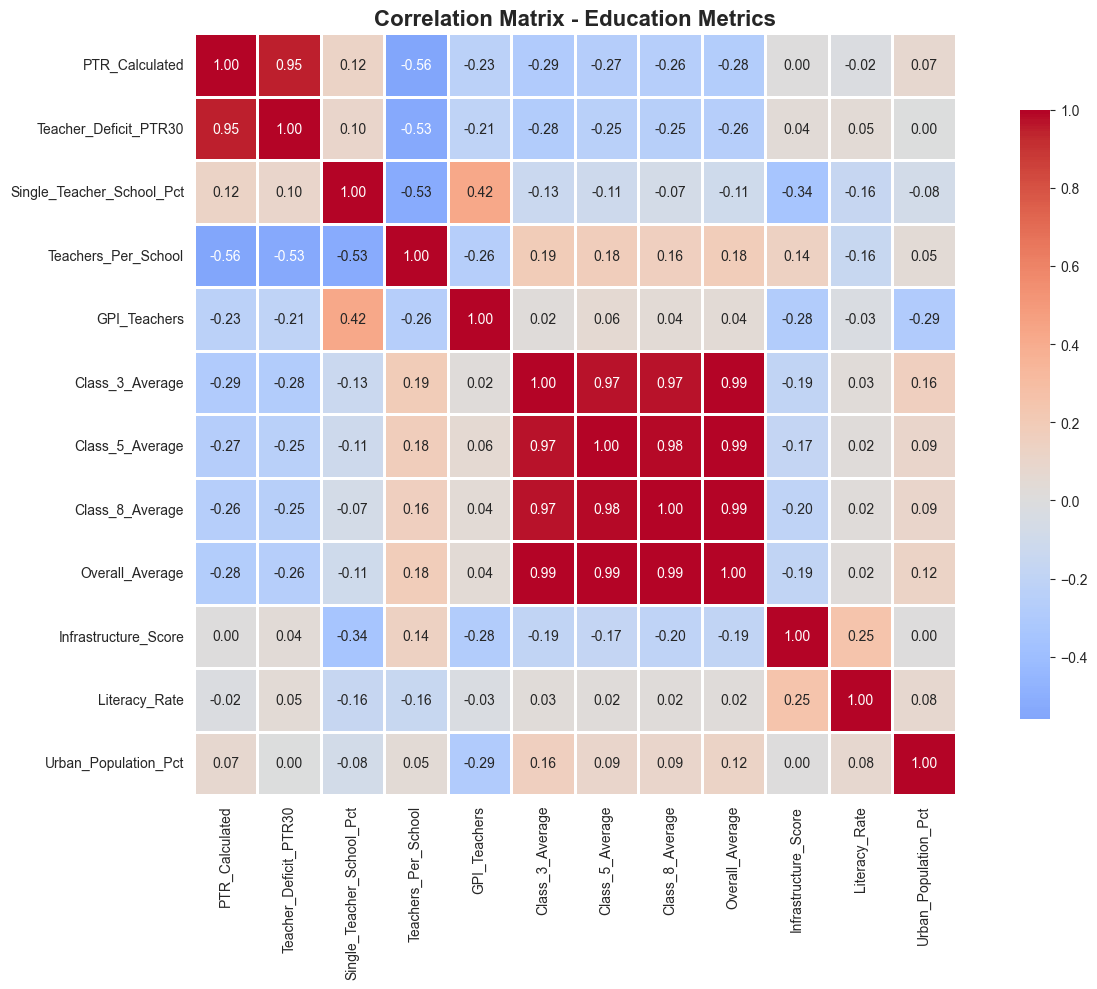

In [16]:
# Correlation Analysis
def correlation_analysis(df):
    """Analyze correlations between teacher metrics and learning outcomes"""
    logger.info("Performing correlation analysis...")
    
    analysis_vars = [
        'PTR_Calculated', 'Teacher_Deficit_PTR30', 'Single_Teacher_School_Pct',
        'Teachers_Per_School', 'GPI_Teachers',
        'Class_3_Average', 'Class_5_Average', 'Class_8_Average', 'Overall_Average',
        'Infrastructure_Score', 'Literacy_Rate', 'Urban_Population_Pct'
    ]
    
    corr_df = df[analysis_vars].copy()
    corr_matrix = corr_df.corr()
    
    # Focus on learning outcomes
    learning_vars = ['Class_3_Average', 'Class_5_Average', 'Class_8_Average', 'Overall_Average']
    teacher_vars = ['PTR_Calculated', 'Teacher_Deficit_PTR30', 'Single_Teacher_School_Pct', 
                    'Teachers_Per_School']
    
    key_correlations = corr_matrix.loc[teacher_vars, learning_vars]
    
    print("\n📊 Key Correlations (Teacher Metrics vs Learning Outcomes):")
    print(key_correlations.round(3))
    
    # Save
    corr_matrix.to_csv(OUTPUT_DIR / 'full_correlation_matrix.csv')
    
    # Visualize
    plt.figure(figsize=(14, 10))
    sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
                square=True, linewidths=1, cbar_kws={"shrink": 0.8})
    plt.title('Correlation Matrix - Education Metrics', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / 'correlation_heatmap.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return corr_matrix


corr_matrix = correlation_analysis(final_df)

In [17]:
# Scatter plot: PTR vs Learning Outcomes
fig = px.scatter(
    final_df,
    x='PTR_Calculated',
    y='Overall_Average',
    size='Total_Enrollment',
    color='Priority_Category',
    hover_name='District',
    title='Pupil-Teacher Ratio vs Learning Outcomes',
    labels={
        'PTR_Calculated': 'Pupil-Teacher Ratio',
        'Overall_Average': 'Overall Learning Outcome (%)',
        'Total_Enrollment': 'Total Enrollment'
    },
    trendline="ols",
    width=1000,
    height=600
)

fig.add_hline(y=final_df['Overall_Average'].mean(), line_dash="dash", 
             line_color="red", annotation_text="State Average")
fig.add_vline(x=30, line_dash="dash", line_color="green", 
             annotation_text="Target PTR (30)")

fig.write_html(OUTPUT_DIR / 'ptr_vs_learning_outcomes.html')
fig.show()

# Calculate correlation
corr = final_df['PTR_Calculated'].corr(final_df['Overall_Average'])
print(f"\n📊 Correlation coefficient (PTR vs Learning Outcomes): {corr:.3f}")


📊 Correlation coefficient (PTR vs Learning Outcomes): -0.277


In [18]:
# Regression Analysis
def regression_analysis(df):
    """Multiple regression: Predict learning outcomes from teacher metrics"""
    logger.info("Performing regression analysis...")
    
    predictors = [
        'PTR_Calculated', 'Teachers_Per_School', 'Single_Teacher_School_Pct',
        'Infrastructure_Score', 'Literacy_Rate', 'Urban_Population_Pct',
        'SC_Enrollment_Pct', 'ST_Enrollment_Pct'
    ]
    
    target = 'Overall_Average'
    
    # Remove NaN
    model_data = df[predictors + [target]].dropna()
    
    X = model_data[predictors]
    y = model_data[target]
    
    # Fit model
    model = LinearRegression()
    model.fit(X, y)
    
    # Predictions
    y_pred = model.predict(X)
    
    # Metrics
    r2 = r2_score(y, y_pred)
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    
    # Feature importance
    feature_importance = pd.DataFrame({
        'Feature': predictors,
        'Coefficient': model.coef_,
        'Abs_Coefficient': np.abs(model.coef_)
    }).sort_values('Abs_Coefficient', ascending=False)
    
    print(f"\n📊 Regression Model Performance:")
    print(f"  R² Score: {r2:.4f}")
    print(f"  RMSE: {rmse:.4f}")
    print(f"\n📊 Top Feature Importances:")
    print(feature_importance.head())
    
    # Save
    feature_importance.to_csv(OUTPUT_DIR / 'feature_importance.csv', index=False)
    
    # Visualize
    fig = px.bar(
        feature_importance.head(8),
        x='Abs_Coefficient',
        y='Feature',
        orientation='h',
        title='Feature Importance - Predicting Learning Outcomes',
        labels={'Abs_Coefficient': 'Absolute Coefficient Value'},
        color='Coefficient',
        color_continuous_scale='RdBu_r'
    )
    fig.write_html(OUTPUT_DIR / 'feature_importance.html')
    fig.show()
    
    return model, feature_importance, r2, rmse


model, feature_imp, r2, rmse = regression_analysis(final_df)

2025-10-30 23:03:45,627 - INFO - Performing regression analysis...



📊 Regression Model Performance:
  R² Score: 0.2807
  RMSE: 9.3678

📊 Top Feature Importances:
                     Feature  Coefficient  Abs_Coefficient
7          ST_Enrollment_Pct        -2.13             2.13
6          SC_Enrollment_Pct         1.33             1.33
2  Single_Teacher_School_Pct        -1.30             1.30
3       Infrastructure_Score        -0.84             0.84
0             PTR_Calculated        -0.48             0.48


In [19]:
# Cluster Analysis
def cluster_analysis(df):
    """Cluster districts by education characteristics"""
    logger.info("Performing cluster analysis...")
    
    cluster_features = [
        'Overall_Average', 'PTR_Calculated', 'Infrastructure_Score',
        'Literacy_Rate', 'Urban_Population_Pct', 'Teacher_Deficit_PTR30'
    ]
    
    cluster_data = df[['District'] + cluster_features].dropna()
    
    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(cluster_data[cluster_features])
    
    # Use 4 clusters
    optimal_k = 4
    kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(X_scaled)
    
    # Add cluster labels
    cluster_data['Cluster'] = clusters
    
    # Cluster summary
    cluster_summary = cluster_data.groupby('Cluster')[cluster_features].agg(['mean', 'count'])
    cluster_summary.columns = ['_'.join(col).strip() for col in cluster_summary.columns.values]
    
    print("\n📊 Cluster Summary:")
    print(cluster_summary)
    
    # PCA for visualization
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)
    
    cluster_data['PC1'] = X_pca[:, 0]
    cluster_data['PC2'] = X_pca[:, 1]
    
    # Visualize
    fig = px.scatter(
        cluster_data,
        x='PC1',
        y='PC2',
        color='Cluster',
        hover_name='District',
        title=f'District Clusters (PCA) - Explained Variance: {pca.explained_variance_ratio_.sum():.2%}',
        labels={'PC1': f'PC1 ({pca.explained_variance_ratio_[0]:.2%})',
                'PC2': f'PC2 ({pca.explained_variance_ratio_[1]:.2%})'},
        color_continuous_scale='viridis',
        width=1000,
        height=600
    )
    fig.write_html(OUTPUT_DIR / 'district_clusters.html')
    fig.show()
    
    # Save
    cluster_data.to_csv(OUTPUT_DIR / 'district_clusters.csv', index=False)
    
    return cluster_data, cluster_summary


cluster_data, cluster_summary = cluster_analysis(final_df)

2025-10-30 23:03:45,865 - INFO - Performing cluster analysis...



📊 Cluster Summary:
         Overall_Average_mean  Overall_Average_count  PTR_Calculated_mean  \
Cluster                                                                     
0                       56.62                      6                36.11   
1                       66.13                     13                28.06   
2                       54.27                      7                36.79   
3                       54.17                     12                31.20   

         PTR_Calculated_count  Infrastructure_Score_mean  \
Cluster                                                    
0                           6                      76.88   
1                          13                      69.41   
2                           7                      67.10   
3                          12                      71.72   

         Infrastructure_Score_count  Literacy_Rate_mean  Literacy_Rate_count  \
Cluster                                                                     

## 7️⃣ Forecasting & Future Requirements

In [20]:
# Generate historical enrollment data
def generate_historical_enrollment_data(df):
    """Generate synthetic historical enrollment data (2015-2025)"""
    logger.info("Generating historical enrollment trends...")
    
    np.random.seed(42)
    
    years = range(2015, 2026)
    historical_data = []
    
    for district in df['District'].unique():
        current_enrollment = df[df['District'] == district]['Total_Enrollment'].iloc[0]
        annual_growth_rate = np.random.uniform(0.01, 0.03)
        
        for year in years:
            years_from_now = 2025 - year
            enrollment = current_enrollment / ((1 + annual_growth_rate) ** years_from_now)
            enrollment = int(enrollment + np.random.normal(0, enrollment * 0.02))
            
            historical_data.append({
                'District': district,
                'Year': year,
                'Enrollment': max(enrollment, 0)
            })
    
    hist_df = pd.DataFrame(historical_data)
    hist_df.to_csv(OUTPUT_DIR / 'historical_enrollment_2015_2025.csv', index=False)
    
    logger.info(f"Generated historical data: {hist_df.shape}")
    
    return hist_df


hist_df = generate_historical_enrollment_data(final_df)
print(f"✅ Historical enrollment data generated. Shape: {hist_df.shape}")

# Visualize trend for sample districts
sample_districts = final_df.nlargest(5, 'Total_Enrollment')['District'].tolist()

fig = px.line(
    hist_df[hist_df['District'].isin(sample_districts)],
    x='Year',
    y='Enrollment',
    color='District',
    title='Historical Enrollment Trends (2015-2025) - Top 5 Districts',
    labels={'Enrollment': 'Total Enrollment'},
    markers=True,
    width=1000,
    height=500
)
fig.write_html(OUTPUT_DIR / 'historical_enrollment_trends.html')
fig.show()

2025-10-30 23:03:46,662 - INFO - Generating historical enrollment trends...
2025-10-30 23:03:46,730 - INFO - Generated historical data: (418, 3)


✅ Historical enrollment data generated. Shape: (418, 3)


In [ ]:
# Forecast enrollment (simple exponential smoothing)
def forecast_enrollment_simple(hist_df, forecast_years=5):
    """Forecast enrollment using simple exponential smoothing"""
    logger.info(f"Forecasting enrollment for {forecast_years} years ahead...")
    
    forecasts = []
    
    for district in hist_df['District'].unique():
        district_data = hist_df[hist_df['District'] == district].sort_values('Year')
        
        try:
            # Use Exponential Smoothing
            model = ExponentialSmoothing(
                district_data['Enrollment'],
                trend='add',
                seasonal=None
            )
            
            fitted_model = model.fit()
            forecast = fitted_model.forecast(steps=forecast_years)
            
            for i, value in enumerate(forecast):
                forecasts.append({
                    'District': district,
                    'Year': 2026 + i,
                    'Forecast_Enrollment': int(max(value, 0)),
                    'Model': 'ExponentialSmoothing'
                })
                
        except Exception as e:
            # Fallback to linear trend
            coeffs = np.polyfit(district_data['Year'], district_data['Enrollment'], 1)
            for i in range(forecast_years):
                year = 2026 + i
                forecast_value = int(max(coeffs[0] * year + coeffs[1], 0))
                forecasts.append({
                    'District': district,
                    'Year': year,
                    'Forecast_Enrollment': forecast_value,
                    'Model': 'LinearTrend'
                })
    
    forecast_df = pd.DataFrame(forecasts)
    forecast_df.to_csv(OUTPUT_DIR / 'enrollment_forecast_2026_2030.csv', index=False)
    
    logger.info(f"Generated forecasts: {forecast_df.shape}")
    
    return forecast_df


forecast_df = forecast_enrollment_simple(hist_df, forecast_years=5)
print(f"✅ Enrollment forecast completed. Shape: {forecast_df.shape}")

# Visualize forecast for sample districts
sample_districts = final_df.nlargest(3, 'Total_Enrollment')['District'].tolist()

# Combine historical and forecast
combined_data = []

for district in sample_districts:
    hist = hist_df[hist_df['District'] == district][['Year', 'Enrollment']].copy()
    hist['Type'] = 'Historical'
    hist['Value'] = hist['Enrollment']
    hist['District'] = district  # Ensure 'District' column is explicitly added
    
    forecast = forecast_df[forecast_df['District'] == district][['Year', 'Forecast_Enrollment']].copy()
    forecast['Type'] = 'Forecast'
    forecast['Value'] = forecast['Forecast_Enrollment']
    
    hist = hist[['District', 'Year', 'Value', 'Type']]
    forecast = forecast.assign(District=district)[['District', 'Year', 'Value', 'Type']]
    
    combined_data.append(pd.concat([hist, forecast]))

combined_df = pd.concat(combined_data)

fig = px.line(
    combined_df,
    x='Year',
    y='Value',
    color='District',
    line_dash='Type',
    title='Enrollment Forecast (2015-2030) - Top 3 Districts',
    labels={'Value': 'Total Enrollment'},
    markers=True,
    width=1000,
    height=500
)
fig.write_html(OUTPUT_DIR / 'enrollment_forecast_2026_2030.html')
fig.show()

2025-10-30 23:07:04,165 - INFO - Forecasting enrollment for 5 years ahead...
2025-10-30 23:07:05,112 - INFO - Generated forecasts: (190, 4)


✅ Enrollment forecast completed. Shape: (190, 4)


In [23]:
# Calculate future teacher requirements
def calculate_teacher_requirements(enrollment_forecast_df, target_ptr=30):
    """Calculate future teacher requirements"""
    logger.info(f"Calculating teacher requirements (target PTR: {target_ptr})...")
    
    teacher_req_df = enrollment_forecast_df.copy()
    teacher_req_df['Required_Teachers'] = (
        teacher_req_df['Forecast_Enrollment'] / target_ptr
    ).round().astype(int)
    
    teacher_req_df.to_csv(OUTPUT_DIR / 'teacher_requirements_forecast.csv', index=False)
    
    return teacher_req_df


teacher_req_df = calculate_teacher_requirements(forecast_df, target_ptr=30)
print(f"✅ Teacher requirements calculated. Shape: {teacher_req_df.shape}")

# Summary by year
yearly_summary = teacher_req_df.groupby('Year').agg({
    'Forecast_Enrollment': 'sum',
    'Required_Teachers': 'sum'
}).reset_index()

print("\n📊 Statewide Teacher Requirements (2026-2030):")
print(yearly_summary)

2025-10-30 23:07:17,620 - INFO - Calculating teacher requirements (target PTR: 30)...


✅ Teacher requirements calculated. Shape: (190, 5)

📊 Statewide Teacher Requirements (2026-2030):
   Year  Forecast_Enrollment  Required_Teachers
0  2026             12679292             422643
1  2027             12868756             428958
2  2028             13058212             435274
3  2029             13247674             441589
4  2030             13437135             447906


In [24]:
# Scenario Analysis
def scenario_analysis(current_df):
    """Perform scenario analysis with different PTR targets"""
    logger.info("Performing scenario analysis...")
    
    scenarios = {
        'Conservative (PTR 35)': 35,
        'Moderate (PTR 30)': 30,
        'Ambitious (PTR 25)': 25,
        'Ideal (PTR 20)': 20
    }
    
    scenario_results = []
    
    total_enrollment_2030 = current_df['Total_Enrollment'].sum()
    projected_enrollment_2030 = int(total_enrollment_2030 * 1.05)  # 5% growth
    
    for scenario_name, target_ptr in scenarios.items():
        required_teachers = int(projected_enrollment_2030 / target_ptr)
        current_teachers = current_df['Total_Teachers'].sum()
        deficit = required_teachers - current_teachers
        annual_recruitment = int(deficit / 5)
        
        scenario_results.append({
            'Scenario': scenario_name,
            'Target_PTR': target_ptr,
            'Projected_Enrollment_2030': projected_enrollment_2030,
            'Required_Teachers_2030': required_teachers,
            'Current_Teachers_2025': current_teachers,
            'Total_Deficit': deficit,
            'Annual_Recruitment_Need': annual_recruitment,
            'Budget_Estimate_Crores': annual_recruitment * 6  # 6L per teacher
        })
    
    scenario_df = pd.DataFrame(scenario_results)
    scenario_df.to_csv(OUTPUT_DIR / 'ptr_scenario_analysis.csv', index=False)
    
    print("\n📊 PTR Scenario Analysis (2025-2030):")
    print(scenario_df.to_string(index=False))
    
    # Visualize
    fig = go.Figure()
    
    fig.add_trace(go.Bar(
        name='Total Deficit',
        x=scenario_df['Scenario'],
        y=scenario_df['Total_Deficit'],
        text=scenario_df['Total_Deficit'],
        textposition='auto',
    ))
    
    fig.update_layout(
        title='Teacher Deficit by PTR Scenario (2025-2030)',
        xaxis_title='Scenario',
        yaxis_title='Total Teacher Deficit',
        width=1000,
        height=500
    )
    
    fig.write_html(OUTPUT_DIR / 'scenario_analysis.html')
    fig.show()
    
    return scenario_df


scenario_df = scenario_analysis(final_df)

2025-10-30 23:07:27,554 - INFO - Performing scenario analysis...



📊 PTR Scenario Analysis (2025-2030):
             Scenario  Target_PTR  Projected_Enrollment_2030  Required_Teachers_2030  Current_Teachers_2025  Total_Deficit  Annual_Recruitment_Need  Budget_Estimate_Crores
Conservative (PTR 35)          35                   13149556                  375701                 399272         -23571                    -4714                  -28284
    Moderate (PTR 30)          30                   13149556                  438318                 399272          39046                     7809                   46854
   Ambitious (PTR 25)          25                   13149556                  525982                 399272         126710                    25342                  152052
       Ideal (PTR 20)          20                   13149556                  657477                 399272         258205                    51641                  309846


## 8️⃣ Visualizations & Reports

In [25]:
# Top and Bottom Performers
print("="*80)
print("🏆 TOP 10 PERFORMING DISTRICTS (Learning Outcomes)")
print("="*80)

top_10 = final_df.nlargest(10, 'Overall_Average')[
    ['District', 'Overall_Average', 'PTR_Calculated', 'Infrastructure_Score', 'Overall_Rank']
]
print(top_10.to_string(index=False))

print("\n" + "="*80)
print("⚠️ BOTTOM 10 PERFORMING DISTRICTS (Learning Outcomes)")
print("="*80)

bottom_10 = final_df.nsmallest(10, 'Overall_Average')[
    ['District', 'Overall_Average', 'PTR_Calculated', 'Infrastructure_Score', 'Overall_Rank']
]
print(bottom_10.to_string(index=False))

🏆 TOP 10 PERFORMING DISTRICTS (Learning Outcomes)
       District  Overall_Average  PTR_Calculated  Infrastructure_Score  Overall_Rank
        Tenkasi            81.47           31.72                 62.11             1
     Sivagangai            81.17           26.02                 68.96             2
        Madurai            81.09           26.79                 70.10             3
  Kanniyakumari            76.29           28.30                 67.01             4
      Cuddalore            75.90           26.15                 65.51             5
     Viluppuram            69.00           36.90                 66.36             6
Tiruchirappalli            68.06           26.54                 77.08             7
 Ramanathapuram            67.39           36.28                 72.75             8
   Virudhunagar            66.95           30.89                 72.92             9
   Nagapattinam            66.35           29.84                 66.04            10

⚠️ BOTTOM 10 P

In [26]:
# Priority Intervention Districts
print("\n" + "="*80)
print("🎯 PRIORITY INTERVENTION DISTRICTS")
print("="*80)

priority_df = final_df[
    final_df['Priority_Category'].isin(['High Priority', 'Critical Priority'])
].sort_values('Priority_Score', ascending=False)

print(f"\nTotal Priority Districts: {len(priority_df)}")
print(f"Critical Priority: {(final_df['Priority_Category'] == 'Critical Priority').sum()}")
print(f"High Priority: {(final_df['Priority_Category'] == 'High Priority').sum()}")

print("\nTop 15 Priority Districts:")
print(priority_df[
    ['District', 'Overall_Average', 'PTR_Calculated', 'Teacher_Deficit_PTR30', 
     'Priority_Score', 'Priority_Category']
].head(15).to_string(index=False))

# Save priority districts
priority_df.to_csv(OUTPUT_DIR / 'priority_intervention_districts.csv', index=False)

# Visualize
fig = px.bar(
    priority_df.head(15).sort_values('Priority_Score'),
    y='District',
    x='Priority_Score',
    color='Priority_Category',
    title='Top 15 Priority Intervention Districts',
    labels={'Priority_Score': 'Priority Score (Higher = More Urgent)'},
    orientation='h',
    width=1000,
    height=600
)
fig.write_html(OUTPUT_DIR / 'priority_districts.html')
fig.show()


🎯 PRIORITY INTERVENTION DISTRICTS

Total Priority Districts: 0
Critical Priority: 0
High Priority: 0

Top 15 Priority Districts:
Empty DataFrame
Columns: [District, Overall_Average, PTR_Calculated, Teacher_Deficit_PTR30, Priority_Score, Priority_Category]
Index: []


In [27]:
# Distribution Plots
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=(
        'PTR Distribution',
        'Learning Outcomes Distribution',
        'Infrastructure Score Distribution',
        'Priority Score Distribution'
    )
)

# PTR Distribution
fig.add_trace(
    go.Histogram(x=final_df['PTR_Calculated'], name='PTR', nbinsx=20,
                marker_color='lightblue'),
    row=1, col=1
)
fig.add_vline(x=30, line_dash="dash", line_color="red", row=1, col=1,
             annotation_text="Target (30)")

# Learning Outcomes Distribution
fig.add_trace(
    go.Histogram(x=final_df['Overall_Average'], name='Learning Outcome', nbinsx=20,
                marker_color='lightgreen'),
    row=1, col=2
)

# Infrastructure Score Distribution
fig.add_trace(
    go.Histogram(x=final_df['Infrastructure_Score'], name='Infrastructure', nbinsx=20,
                marker_color='lightcoral'),
    row=2, col=1
)

# Priority Score Distribution
fig.add_trace(
    go.Histogram(x=final_df['Priority_Score'], name='Priority', nbinsx=20,
                marker_color='lightyellow'),
    row=2, col=2
)

fig.update_layout(
    height=800,
    width=1200,
    title_text="Education Metrics Distributions",
    showlegend=False
)

fig.write_html(OUTPUT_DIR / 'distributions.html')
fig.show()

## 9️⃣ Policy Recommendations

In [28]:
print("="*80)
print("💡 POLICY RECOMMENDATIONS")
print("="*80)

print("\n1️⃣ TEACHER RECRUITMENT")
print("-" * 80)
print(f"   • Immediate Requirement: {final_df['Teacher_Deficit_PTR30'].sum():,} teachers (PTR 30)")
print(f"   • Ambitious Target: {final_df['Teacher_Deficit_PTR25'].sum():,} teachers (PTR 25)")
print(f"   • Focus on {len(priority_df)} priority districts")
print(f"   • Address {final_df['Single_Teacher_Schools'].sum():,} single-teacher schools")

print("\n2️⃣ LEARNING OUTCOME IMPROVEMENTS")
print("-" * 80)
low_performing = final_df[final_df['Overall_Average'] < final_df['Overall_Average'].quantile(0.25)]
print(f"   • {len(low_performing)} districts below 25th percentile")
print(f"   • Strengthen English and Mathematics instruction")
print(f"   • Subject-specific teacher training programs")
print(f"   • Remedial programs in underperforming districts")

print("\n3️⃣ INFRASTRUCTURE DEVELOPMENT")
print("-" * 80)
low_infra = final_df[final_df['Infrastructure_Score'] < 60]
print(f"   • {len(low_infra)} districts need infrastructure upgrades")
print(f"   • Priority: Digital infrastructure (internet connectivity)")
print(f"   • Library and computer lab facilities")
print(f"   • Estimated Budget: ₹{(len(low_infra) * 50):.0f} crores")

print("\n4️⃣ EQUITY & INCLUSION")
print("-" * 80)
print(f"   • Focus on SC/ST enrollment and retention")
print(f"   • Rural-urban disparity reduction programs")
print(f"   • Special attention to tribal districts (Nilgiris, Dharmapuri, Krishnagiri)")
print(f"   • Gender parity initiatives")

print("\n5️⃣ MONITORING & EVALUATION")
print("-" * 80)
print(f"   • Quarterly PTR monitoring")
print(f"   • Annual learning outcome assessments")
print(f"   • District-level dashboards")
print(f"   • Data-driven decision making")

print("\n" + "="*80)

💡 POLICY RECOMMENDATIONS

1️⃣ TEACHER RECRUITMENT
--------------------------------------------------------------------------------
   • Immediate Requirement: 18,177 teachers (PTR 30)
   • Ambitious Target: 101,666 teachers (PTR 25)
   • Focus on 0 priority districts
   • Address 1,421 single-teacher schools

2️⃣ LEARNING OUTCOME IMPROVEMENTS
--------------------------------------------------------------------------------
   • 10 districts below 25th percentile
   • Strengthen English and Mathematics instruction
   • Subject-specific teacher training programs
   • Remedial programs in underperforming districts

3️⃣ INFRASTRUCTURE DEVELOPMENT
--------------------------------------------------------------------------------
   • 0 districts need infrastructure upgrades
   • Priority: Digital infrastructure (internet connectivity)
   • Library and computer lab facilities
   • Estimated Budget: ₹0 crores

4️⃣ EQUITY & INCLUSION
---------------------------------------------------------------

## 🔟 Export Summary Report

In [29]:
# Create comprehensive summary report
summary_report = {
    'report_date': datetime.now().strftime('%Y-%m-%d'),
    'total_districts': len(final_df),
    'total_schools': int(final_df['Total_Schools'].sum()),
    'total_enrollment': int(final_df['Total_Enrollment'].sum()),
    'total_teachers': int(final_df['Total_Teachers'].sum()),
    'state_avg_ptr': float(final_df['PTR_Calculated'].mean()),
    'state_avg_learning_outcome': float(final_df['Overall_Average'].mean()),
    'single_teacher_schools': int(final_df['Single_Teacher_Schools'].sum()),
    'teacher_deficit_ptr30': int(final_df['Teacher_Deficit_PTR30'].sum()),
    'teacher_deficit_ptr25': int(final_df['Teacher_Deficit_PTR25'].sum()),
    'districts_below_state_avg': int((final_df['Overall_vs_State'] < 0).sum()),
    'districts_ptr_above_35': int((final_df['PTR_Calculated'] > 35).sum()),
    'avg_infrastructure_score': float(final_df['Infrastructure_Score'].mean()),
    'priority_districts_count': len(priority_df),
    'correlation_ptr_learning': float(final_df['PTR_Calculated'].corr(final_df['Overall_Average'])),
    'regression_r2': float(r2),
}

summary_df = pd.DataFrame([summary_report])
summary_df.to_csv(OUTPUT_DIR / 'summary_report.csv', index=False)

print("✅ Summary report generated!")
print("\n📊 Key Findings:")
for key, value in summary_report.items():
    print(f"   {key}: {value}")

✅ Summary report generated!

📊 Key Findings:
   report_date: 2025-10-30
   total_districts: 38
   total_schools: 36503
   total_enrollment: 12523387
   total_teachers: 399272
   state_avg_ptr: 31.93342105263158
   state_avg_learning_outcome: 58.66578947368421
   single_teacher_schools: 1421
   teacher_deficit_ptr30: 18177
   teacher_deficit_ptr25: 101666
   districts_below_state_avg: 21
   districts_ptr_above_35: 12
   avg_infrastructure_score: 70.89342105263158
   priority_districts_count: 0
   correlation_ptr_learning: -0.27688217377280616
   regression_r2: 0.2807171942598622


In [30]:
# List all generated files
print("\n" + "="*80)
print("📁 GENERATED FILES")
print("="*80)

print("\n📂 Raw Data:")
for file in RAW_DATA_DIR.glob('*.csv'):
    print(f"   • {file.name}")

print("\n📂 Processed Data:")
for file in PROCESSED_DATA_DIR.glob('*.csv'):
    print(f"   • {file.name}")

print("\n📂 Analysis Outputs:")
for file in OUTPUT_DIR.glob('*'):
    print(f"   • {file.name}")

print("\n" + "="*80)
print("✅ ANALYSIS COMPLETE!")
print("="*80)


📁 GENERATED FILES

📂 Raw Data:
   • demographic_data_2025.csv
   • slas_2025_learning_outcomes.csv
   • udise_plus_2024_25.csv

📂 Processed Data:
   • demographic_clean.csv
   • slas_2025_clean.csv
   • tn_education_integrated.csv
   • udise_2024_25_clean.csv

📂 Analysis Outputs:
   • correlation_heatmap.png
   • distributions.html
   • district_clusters.csv
   • district_clusters.html
   • enrollment_forecast_2026_2030.csv
   • enrollment_forecast_2026_2030.html
   • feature_importance.csv
   • feature_importance.html
   • full_correlation_matrix.csv
   • historical_enrollment_2015_2025.csv
   • historical_enrollment_trends.html
   • priority_districts.html
   • priority_intervention_districts.csv
   • ptr_scenario_analysis.csv
   • ptr_vs_learning_outcomes.html
   • scenario_analysis.html
   • summary_report.csv
   • teacher_requirements_forecast.csv

✅ ANALYSIS COMPLETE!
